In [1]:
import os

parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import SimpleITK as sitk

from volumetry.plotting import *
from volumetry.methods import ellipsoid_method, voxels_volume
from volumetry.utils import divide_image, find_kidney_slices

In [42]:
image_path = '../data/po/out_nerka_Moving2_SPLINE.mhd'
segmentation_path = '../data/po/TOTAL.mhd'

In [43]:
image = sitk.ReadImage(image_path, sitk.sitkFloat32)
segmentation = sitk.ReadImage(segmentation_path, sitk.sitkFloat32)

In [44]:
left_image, right_image = divide_image(image)
left_segmentation, right_segmentation = divide_image(segmentation)

In [45]:
left_image.shape

(159, 195, 147)

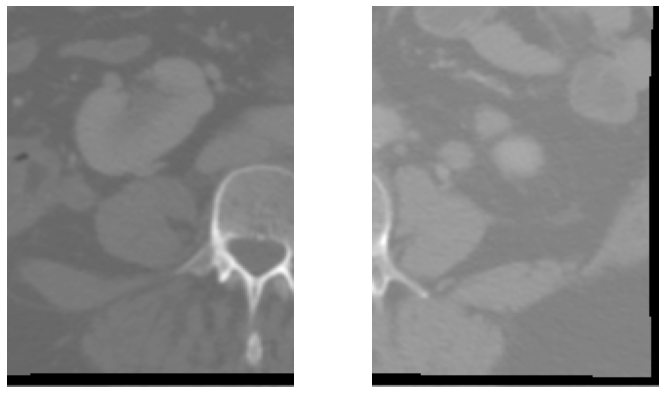

In [46]:
plot_two_images(left_image[70], right_image[70])

In [47]:
voxels_volume(segmentation, left_segmentation)

113404.65467553

In [48]:
voxels_volume(segmentation, right_segmentation)

126186.51861806399

In [54]:
first, last, max_idx = find_kidney_slices(left_segmentation)
# volume, xs, ys = ellipsoid_method(left_segmentation[max_idx], first, last)
# volume

In [55]:
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

edges = canny(left_segmentation[max_idx])

ellipses = hough_ellipse(edges)
print(len(ellipses))
ellipses = np.array([params for params in ellipses if params['a'] != 0 and params['b'] > 15])
ellipses.sort(order=['a', 'b'])
param = list(ellipses[-1])


yc, xc, a, b = [int(round(x)) for x in param[1:5]]
print(a, b)
orientation = param[5]
xs, ys = ellipse_perimeter(yc, xc, a, b, orientation)

c = last - first
volume = a * b * c * np.pi * (2 / 3)

66098
43 16


In [56]:
c

85

In [57]:
volume

122480.22558795406

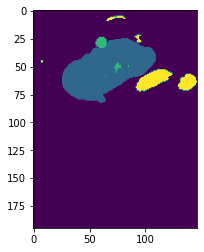

In [63]:
plt.imshow(left_segmentation[max_idx])

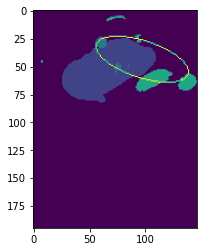

In [64]:
import numpy as np
import matplotlib.pyplot as plt

ellipse_image = np.copy(left_segmentation[max_idx])
ellipse_image[xs, ys] = 5
plt.imshow(ellipse_image)
plt.show()